In [88]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib nbagg
from scipy import signal
import mpl_toolkits.mplot3d.art3d as art3d
from astropy.stats import sigma_clip

Populating the interactive namespace from numpy and matplotlib


In [142]:
"""
Full Ch 1 LS1
"""
data_01 = pd.read_csv('https://raw.githubusercontent.com/AmeVel2040/myPiFiles/main/LSStuffAmeya/14-06-22at01-28PM')
startT=data_01.columns[0]
data_01=data_01.drop(columns=['d1','d2','d3'])
data_01.columns = ["Time","d0"]
print(startT)
print(data_01)
xfull,yfull = data_01.iloc[:,0].values/1E6, data_01.iloc[:,1].values
x,y=xfull,yfull


1655242085556488
           Time        d0
0         22184  0.775999
1         53800  0.778213
2         80215  0.788714
3        105129  0.777429
4        130849  0.790678
...         ...       ...
3504  123117672  0.651944
3505  123142948  0.661558
3506  123167837  0.654079
3507  123213428  0.668784
3508  123239706  0.659662

[3509 rows x 2 columns]


           Time        d0    tdiff
0         22184  0.775999      NaN
1         53800  0.778213  31616.0
2         80215  0.788714  26415.0
3        105129  0.777429  24914.0
4        130849  0.790678  25720.0
...         ...       ...      ...
3504  123117672  0.651944  24690.0
3505  123142948  0.661558  25276.0
3506  123167837  0.654079  24889.0
3507  123213428  0.668784  45591.0
3508  123239706  0.659662  26278.0

[3509 rows x 3 columns]
           Time        d0    tdiff
0         22184  0.775999      NaN
1         53800  0.778213  31616.0
2         80215  0.788714  26415.0
3        105129  0.777429  24914.0
4        130849  0.790678  25720.0
...         ...       ...      ...
3504  123117672  0.651944  24690.0
3505  123142948  0.661558  25276.0
3506  123167837  0.654079  24889.0
3507  123213428  0.668784  45591.0
3508  123239706  0.659662  26278.0

[3502 rows x 3 columns]
0.03267300885461297


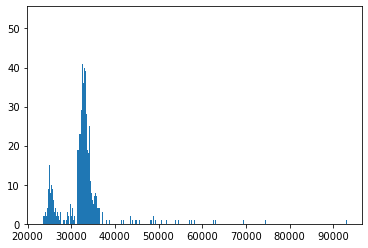

In [143]:
data_01["tdiff"]=data_01['Time'] - data_01['Time'].shift(1)
print(data_01)
data_01=data_01.drop(data_01[(data_01["tdiff"]>100000)].index)
print(data_01)
plt.hist(data_01["tdiff"],bins=2000)
print(data_01["tdiff"].mean()/1E6)

In [147]:
start=0
firstChange=754 #Connection to 2/3 power
secondChange=3536 #Disconnection
thirdChange=3596 #Connection to FullPower

tchunk1=x[start:-1]
vchunk1=y[start:-1] #OFF
print(tchunk1.shape)
print(vchunk1.shape)

(3508,)
(3508,)


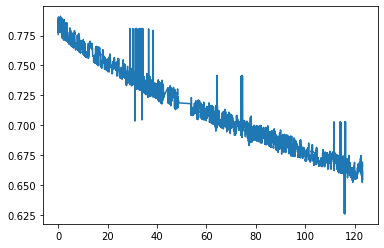

In [145]:
plt.plot(tchunk1,vchunk1)

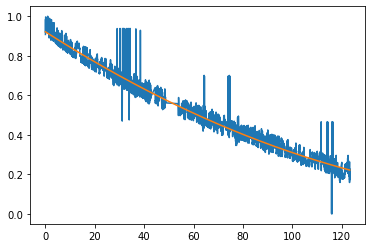

           2
1.879e-05 x - 0.007994 x + 0.9215


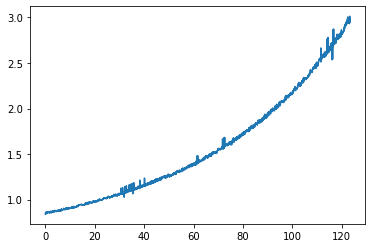

In [232]:
normv=(vchunk1-vchunk1.min())/(vchunk1.max()-vchunk1.min())
z=np.polyfit(tchunk1,normv,deg=2)
p=np.poly1d(z)
xp=np.linspace(min(tchunk1),max(tchunk1),len(tchunk1)+1)
yp=p(xp)
div=y/yp
plt.plot(tchunk1,normv)
plt.plot(xp,yp)
plt.show()
plt.plot(xp,div)
print(p)

123


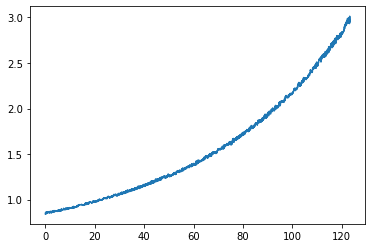

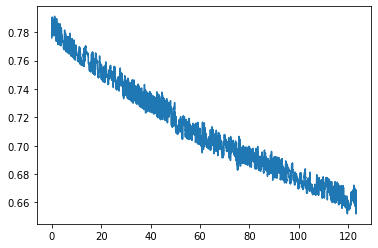

In [260]:
def three_sigmad(nt,nv,chunks):
    data = np.row_stack((nt,nv))
    out = np.copy(data)
    i=0
    size=round(data.shape[1]/chunks)
    deleted=0
    while i < chunks:
        chunk = data[:, i*size:(i+1)*size]
        #print(chunk.shape)
        lower_bound = chunk[1,:].mean() - 2 * np.std(chunk[1,:],ddof=1)
        upper_bound = chunk[1,:].mean() + 2 * np.std(chunk[1,:],ddof=1)
        for x in range(chunk.shape[1]):
            if chunk[1,x] >= upper_bound or chunk[1,x] <= lower_bound:
                #print("True")
                out=np.delete(out,x+i*size-deleted,axis=1)
                deleted+=1
                
        i+=1
    print(deleted)
    return out[0,:],out[1,:]    
newt, newv=three_sigmad(xp,div,125)
plot(newt,newv)
plt.show()
unnormv=newv*p(newt)
plot(newt,unnormv)

In [335]:
fs=600
fs2=100
fclip, tclip, Sxxclip = signal.spectrogram(unnormv, fs,nperseg=256)
fclip2, tclip2, Sxxclip2 = signal.spectrogram(unnormv, fs2,nperseg=256)
print(Sxxclip)

[[3.33196081e-10 1.37790764e-08 1.49278049e-08 ... 2.21231111e-08
  3.32706559e-10 7.24692624e-08]
 [6.63750112e-06 1.16219023e-06 3.06679220e-06 ... 1.13559313e-06
  1.07204438e-06 1.08693582e-06]
 [1.36466365e-06 4.05317089e-06 6.45656420e-07 ... 2.12361029e-07
  7.06536359e-07 6.74591196e-07]
 ...
 [1.39296532e-07 3.66698521e-08 3.56672998e-08 ... 1.41283980e-09
  2.71077715e-08 1.28312027e-08]
 [3.16699011e-08 2.18323021e-08 5.17781231e-08 ... 2.80796864e-08
  5.45614587e-08 5.50746606e-08]
 [1.63500071e-07 1.31216373e-08 4.20961878e-09 ... 7.88054101e-10
  1.31187731e-08 2.73602358e-09]]


C:\Users\ameya\AppData\Local\Temp/ipykernel_7196/1780251167.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  s_22 = axs[0].pcolormesh(tclip, fclip, Sxxclip,cmap='binary',vmin=min(Sxxclip[0]),vmax=max(Sxxclip[0]))
C:\Users\ameya\AppData\Local\Temp/ipykernel_7196/1780251167.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([24*i for i in range(6)])
C:\Users\ameya\AppData\Local\Temp/ipykernel_7196/1780251167.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'

Text(0.5, 0, 'Time [s]')

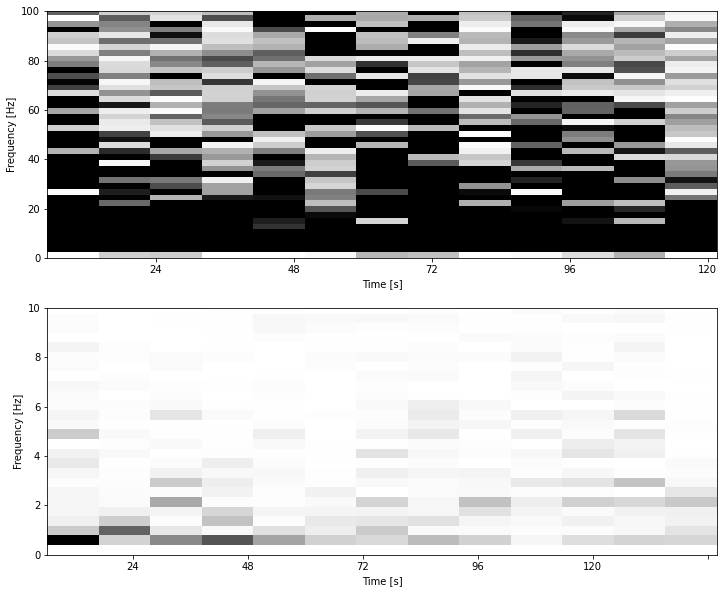

In [336]:
fig, axs = plt.subplots(2, 1,figsize=(12,10))
s_22 = axs[0].pcolormesh(tclip, fclip, Sxxclip,cmap='binary',vmin=min(Sxxclip[0]),vmax=max(Sxxclip[0]))
axs[0].set_ylim(0,100)
axs[0].set_xticklabels([24*i for i in range(6)])
axs[0].set_ylabel('Frequency [Hz]')
axs[0].set_xlabel('Time [s]')

s_22 = axs[1].pcolormesh(tclip2, fclip2, Sxxclip2,cmap='binary')
axs[1].set_ylim(0,10)
axs[1].set_xticklabels([24*i for i in range(6)])
axs[1].set_ylabel('Frequency [Hz]')
axs[1].set_xlabel('Time [s]')